# Covariate shift: hidden problems in real world data science

## Introduction

Time flies, two years have passed since I posted my first blog at https://ruoyunlin.github.io. 

Here I am again, to announce the topic of this year's first post will be (drumroll, please)...COVARIATE SHIFT!

This was actually inspired by a recent task I had at work. After a couple of weeks of researching and implementing the covariate shift correction in production, I would like to share a few learnings. 

<!--more-->

### Outline

In this notebook, **two demos** are used to explain the issue of **covariate shift** and to show how to **fix** it.

In addition, there are **two easy quizzes** throughout this post to help you check your understanding of the key concepts. You can find the answers to the quizzes at the end of the post.

I have also added a few **advanced topics and FAQs** (yes, after the summary section, which is prepared for advanced learners). 

### A few more words

Covariate shift is a common issue that data scientists often encounter in the real world. However, not enough attention was paid to it. 

At least I was not paying enough attention to this issue before my colleague Alex brought it up. He shared this concept with us using an easy demo (similar to Demo 1 in this post), which helps quite a lot for us to understand the potential issue that we might have at work. So a big thanks to my colleague.

As a machine learning beginner, it is fine if you can grasp the idea of covariate shift and have a basic understanding of how to fix it (as indicated in Demo 1 and 2). The key takeaways will be addressed in the Summary as well.

For those data scientists who already have some hands-on experiences, it is important to have a deeper understanding of this issue:

- Does my model have the issue of covariate shift?
- What are the most-used methods of dealing with covariate shift?
- Any caveats in implementing the covariate shift correction?

Hence, it is recommended to read through the section of the advanced topics and FAQs and check out the simulations. 

The FAQs are actually the questions that popped up during the implementation of the covariate shift correction.
I was trying to think deeper about questions like 1) whether my dataset indeed has the issue of covariate shift and 2) whether my correction is going to improve the model or make it worse. Hence, I ran a few simulations to solve my own doubts. This part contains my main learnings. I hope it can also help you with your work. 

Now, let's begin the journey!


### Hold on, what is covariate shift?

**Covariate shift** refers to **changes in the distribution of features in the training and test dataset**. 

For those who still have no idea after reading the sentence above, please read the background knowledge session below. Otherwise, please directly go to the first quiz :)

-------

## Background knowledge

### Warning: Jargon ahead
**Training dataset**: A set of examples used to fit the parameters of a model.

**Test dataset**: Dataset used to provide an unbiased evaluation of the model fit on the training data set.

**Target**: Output variable or dependent variable of the model, the target we want to predict, usually donated by y. 

**Feature**: Input variable or independent variable in the model, it can also be called as covariate, usually donated by x. One model can have one or more features.

**Model**: a function of feature(s) to predict the target. 


### What is linear regression?

A simple example of a machine learning model is a linear regression model:


![image.png](https://datascience.foundation/img/pdf_images/understanding_of_linear_regression_with_python_1.png)


One way to validate a linear regression model is to use [Root-Mean-Square-Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation), which is also called as RMSE. 

**The smaller the RMSE, the better the model fits the data.**

If you want to know more about linear regression, please feel free to watch the youtube video [here](https://www.youtube.com/watch?v=nk2CQITm_eo&ab_channel=StatQuestwithJoshStarmer).

### What is a classifier?

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression#:~:text=In%20statistics%2C%20linear%20regression%20is,as%20dependent%20and%20independent%20variables) is for predicting a continuous target variable. 

What if our target variable is a dummy variable (e.g., yes or no)? 

![image.png](https://miro.medium.com/proxy/1*fBjniQPOKigqxYSKEumXoA.png)

There are also quite a few [classification](https://en.wikipedia.org/wiki/Statistical_classification) models like [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), [multilayer perception classifier](https://en.wikipedia.org/wiki/Multilayer_perceptron).

It is beyond the scope of this session to introduce these concepts in detail. 

You just need to know a classifier is a model that predicts a classification problem based on a list of features.

And it is also important to know a few concepts about the validation of a classifier (e.g., [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), accuracy, [precision, and recall](https://en.wikipedia.org/wiki/Precision_and_recall)): 


![image.png](https://www.researchgate.net/publication/336402347/figure/fig3/AS:812472659349505@1570719985505/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix.ppm)

**The higher these scores, the better the model is.**



----------
## What is covariate shift?

**Covariate shift** refers to the **changes in the distribution of features in the training and test dataset**.

It is often called as **data drift**, **feature drift**, or **population shift**. 

In the image below (left), we can see that the input density are different between the train and test dataset.

If we train a model using the training samples (i.e., blue dots in the right pic), we will get an inaccurate model for predicting the test sample (i.e., black dots in the right pic).

<img src="https://i.ibb.co/5410vjZ/covariate-shift-example.png" width="1000" />

### **Quiz 1**: Which example below (left vs. right) is more likely to have the issue of covariate shift?

You can find the answer in the end of this post.

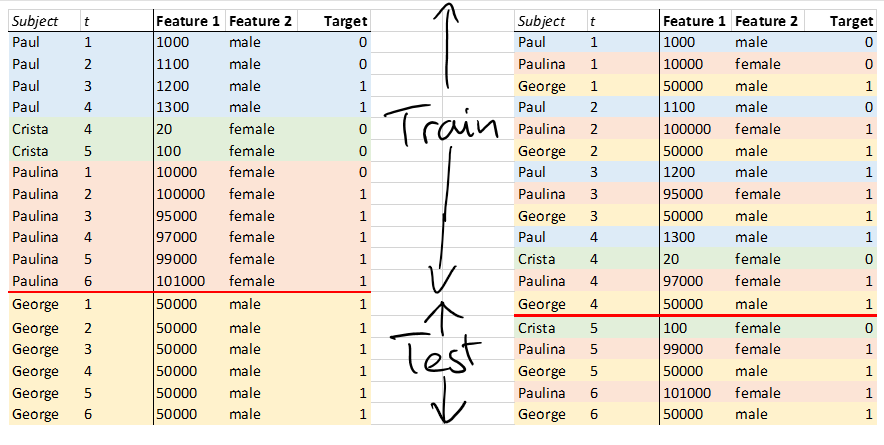

--------
## What is covariate shift correction?

The key idea behind the covariate shift correction is to train a **reweighted** model.

It puts **more weight on the samples with feature values that are more frequently shown in the test set**, and vice versa.


You might wonder how to calculate the weight, so here come two demos:

- Demo 1: a simple example with only **one feature** in the dataset and it provides an **intuitive solution**
- Demo 2: an example with **two features** and uses a more **general approach** to correct for the covariate shift


------
# Demo 1: An intuitive example with one feature only

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits import mplot3d
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import precision_score, recall_score
from sklearn.neural_network import MLPClassifier

np.random.seed(1234)

%load_ext watermark

The following packages were used:

In [2]:
%watermark --iversions

pandas     : 1.3.5
numpy      : 1.20.2
statsmodels: 0.12.2
seaborn    : 0.11.1
matplotlib : 3.2.1



## Data Preparation
### Prepare a target function with only 1 feature

Let us assume the relationship between x and y is as following:
$f(x) = -x^2 + x + 1$ 

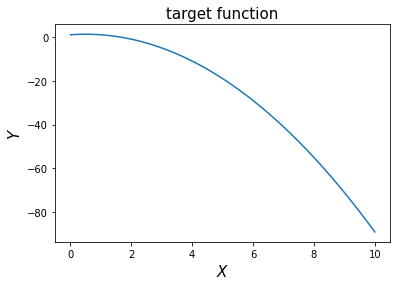

In [3]:
def target_func(x, eps=-1):
    return eps * x ** 2 + x + 1


x = np.linspace(0, 10, 100)

plt.xlabel("$X$", fontsize=15)
plt.ylabel("$Y$", fontsize=15)
plt.plot(x, target_func(x))
plt.title("target function", fontsize=15);

### Prepare the train and test dataset (n=1000)

Then we generate the two sets of x distributions for training and test set (see the first two charts below).

Hence, the train and test data were generated by adding some random error on top of the expected y value for each x.

In [4]:
def get_obs_y(obs_x, eps=-1):
    np.random.seed(1234)
    return target_func(obs_x, eps) + np.random.normal(0, 10, size=obs_x.shape[0])


# set parameters
sample_size = 1000
max_x = 10
x_range = np.array(range(max_x))

# prepare different probability distribution for train and test data
test_weights = [(1 + i) / ((max_x + 1) * max_x / 2) for i in x_range]
train_weights = test_weights[::-1]

# generate x, y, and best fitting line for train data
x_train_list = np.random.choice(x_range, p=train_weights, size=sample_size)
y_train_list = get_obs_y(x_train_list)
linreg_train = sm.OLS(y_train_list, sm.add_constant(x_train_list)).fit()

# generate x, y, and best fitting line for test data
x_test_list = np.random.choice(x_range, p=test_weights, size=sample_size)
y_test_list = get_obs_y(x_test_list)
linreg_test = sm.OLS(y_test_list, sm.add_constant(x_test_list)).fit()

# prepare distribution plot for train and test set
def prepare_distribution(x_list):
    df = pd.DataFrame(x_list)
    df.columns = ["x"]
    df = df.groupby("x").agg({"x": "count"})
    df.columns = ["frequency"]
    df = df.reset_index()
    return df


dist_test = prepare_distribution(x_test_list)
dist_train = prepare_distribution(x_train_list)

### Visualize results

Now we can see that the best fitting line from the training and the test set are different from each other (see in the last chart below for a comparison).

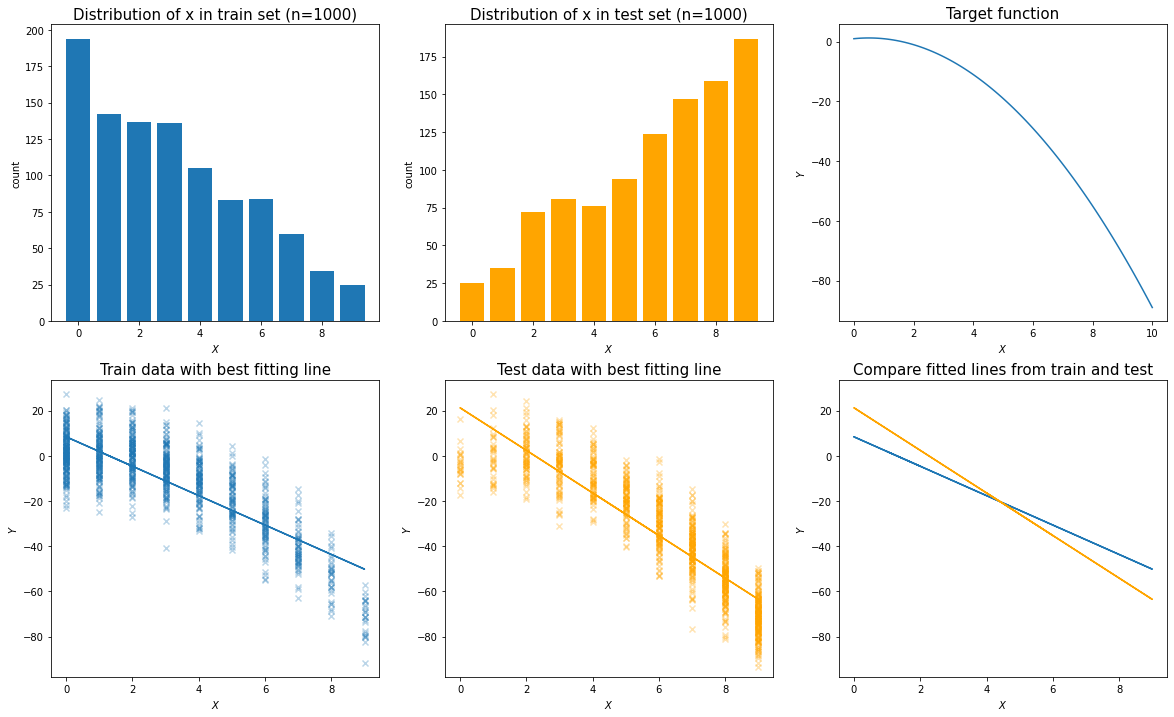

In [5]:
# visualize data
fig, axes = plt.subplots(figsize=(20, 12), ncols=3, nrows=2)
axes = axes.flatten()

axes[0].set_title(f"Distribution of x in train set (n={sample_size})", fontsize=15)
axes[0].bar(dist_train["x"], dist_train["frequency"])
axes[0].set_xlabel("$X$")
axes[0].set_ylabel("count")

axes[1].set_title(f"Distribution of x in test set (n={sample_size})", fontsize=15)
axes[1].bar(dist_test["x"], dist_test["frequency"], color="orange")
axes[1].set_xlabel("$X$")
axes[1].set_ylabel("count")

axes[2].set_title("Target function", fontsize=15)
x = np.linspace(0, 10, 100)
axes[2].plot(x, target_func(x))
axes[2].set_xlabel("$X$")
axes[2].set_ylabel("$Y$")

axes[3].set_title("Train data with best fitting line", fontsize=15)
axes[3].scatter(x_train_list, y_train_list, alpha=0.3, marker="x")
axes[3].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[3].set_xlabel("$X$")
axes[3].set_ylabel("$Y$")

axes[4].set_title("Test data with best fitting line", fontsize=15)
axes[4].scatter(x_test_list, y_test_list, color="orange", alpha=0.3, marker="x")
axes[4].plot(
    x_test_list, linreg_test.predict(sm.add_constant(x_test_list)), color="orange"
)
axes[4].set_xlabel("$X$")
axes[4].set_ylabel("$Y$")
axes[4].set_ylim(axes[3].get_ylim())

axes[5].set_title("Compare fitted lines from train and test", fontsize=15)
axes[5].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[5].plot(
    x_test_list, linreg_test.predict(sm.add_constant(x_test_list)), color="orange"
)
axes[5].set_xlabel("$X$")
axes[5].set_ylabel("$Y$")
axes[5].set_ylim(axes[3].get_ylim())
plt.show()

## An intuitive solution

Remember that our **goal** is to generate an **accurate model for the test data**. 

When there is a big difference in the feature distribution between the train and test dataset, we need to correct it by **adjusting the weight of samples in the test set**.

But how can we find the best weight to apply?

**Intuitively speaking, we should use the ratio of the probability distribution of x: $\frac{P\_test(x)}{P\_train(x)}$**


We already know the probability distribution of the feature in the train and test dataset

$P\_train(x)$:

In [6]:
dist_train["p"] = dist_train["frequency"] / (dist_train["frequency"].sum())
dist_train

,x,frequency,p
0,0,194,0.194
1,1,142,0.142
2,2,137,0.137
3,3,136,0.136
4,4,105,0.105
5,5,83,0.083
6,6,84,0.084
7,7,60,0.060
8,8,34,0.034
9,9,25,0.025


$P\_test(x)$:

In [7]:
dist_test["p"] = dist_test["frequency"] / (dist_test["frequency"].sum())
dist_test

,x,frequency,p
0,0,25,0.025
1,1,35,0.035
2,2,72,0.072
3,3,81,0.081
4,4,76,0.076
5,5,94,0.094
6,6,124,0.124
7,7,147,0.147
8,8,159,0.159
9,9,187,0.187


### **Quiz 2**: which weight below is the correct one?

**Option A: putting more weights when x is smaller**

In [8]:
# Option A:
weight = dist_train["p"] / dist_test["p"]
pd.DataFrame({"x": weight.index, "weight": weight.values})

,x,weight
0,0,7.760000
1,1,4.057143
2,2,1.902778
3,3,1.679012
4,4,1.381579
5,5,0.882979
6,6,0.677419
7,7,0.408163
8,8,0.213836
9,9,0.133690


**Option B: putting more weights when x is larger**

In [9]:
# Option B:
weight = dist_test["p"] / dist_train["p"]
pd.DataFrame({"x": weight.index, "weight": weight.values})

,x,weight
0,0,0.128866
1,1,0.246479
2,2,0.525547
3,3,0.595588
4,4,0.723810
5,5,1.132530
6,6,1.476190
7,7,2.450000
8,8,4.676471
9,9,7.480000


### Fit the best line in the train set after re-weighting

In [10]:
weight = dist_test["p"] / dist_train["p"]
weight_dict = weight.to_dict()
weight_list = [weight_dict[x] for x in x_train_list]

# retrain the model using re-weighted sample
weighted_linreg_train = sm.WLS(
    y_train_list, sm.add_constant(x_train_list), weight_list
).fit()

### Visualize the results

Now we can see the best fitting line after re-weighting (the black line in the left bottom chart) is overlapping with the orange line (in the right bottom chart).

The reweighted model performs better than before regarding the test sample.

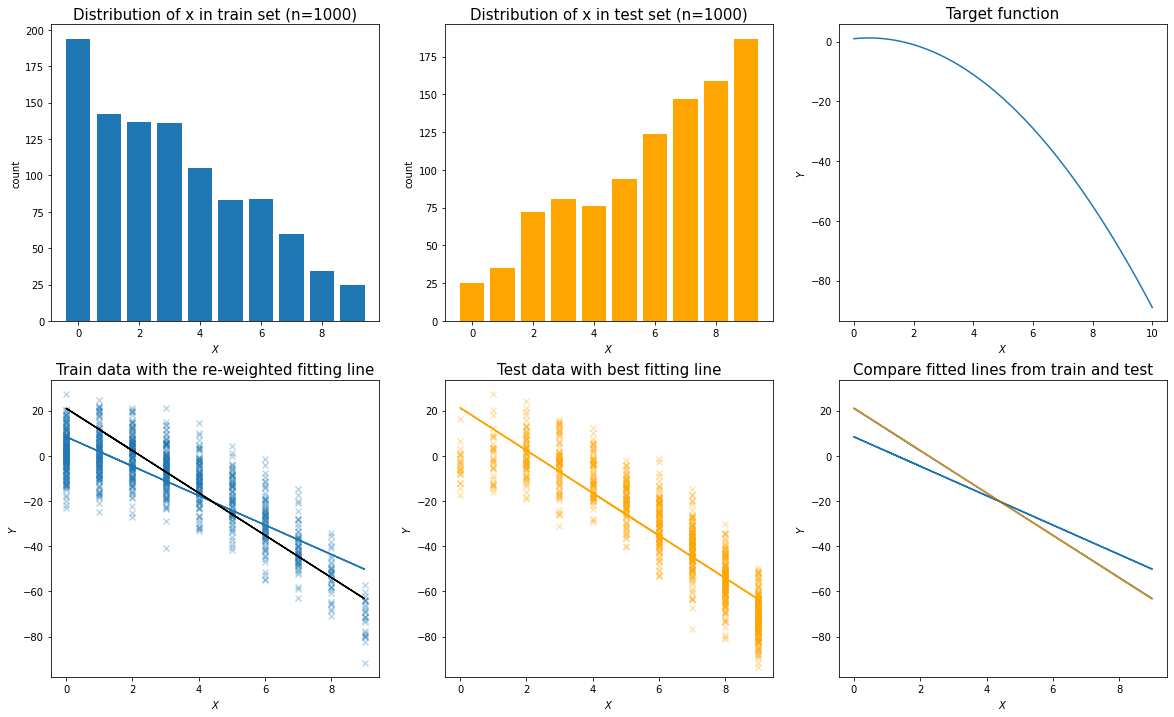

In [11]:
# visualize data
fig, axes = plt.subplots(figsize=(20, 12), ncols=3, nrows=2)
axes = axes.flatten()

axes[0].set_title(f"Distribution of x in train set (n={sample_size})", fontsize=15)
axes[0].bar(dist_train["x"], dist_train["frequency"])
axes[0].set_xlabel("$X$")
axes[0].set_ylabel("count")

axes[1].set_title(f"Distribution of x in test set (n={sample_size})", fontsize=15)
axes[1].bar(dist_test["x"], dist_test["frequency"], color="orange")
axes[1].set_xlabel("$X$")
axes[1].set_ylabel("count")

axes[2].set_title("Target function", fontsize=15)
x = np.linspace(0, 10, 100)
axes[2].plot(x, target_func(x))
axes[2].set_xlabel("$X$")
axes[2].set_ylabel("$Y$")

axes[3].set_title("Train data with the re-weighted fitting line", fontsize=15)
axes[3].scatter(x_train_list, y_train_list, alpha=0.3, marker="x")
axes[3].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[3].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
)
axes[3].set_xlabel("$X$")
axes[3].set_ylabel("$Y$")

axes[4].set_title("Test data with best fitting line", fontsize=15)
axes[4].scatter(x_test_list, y_test_list, color="orange", alpha=0.3, marker="x")
axes[4].plot(
    x_test_list, linreg_test.predict(sm.add_constant(x_test_list)), color="orange"
)
axes[4].set_xlabel("$X$")
axes[4].set_ylabel("$Y$")
axes[4].set_ylim(axes[3].get_ylim())

axes[5].set_title("Compare fitted lines from train and test", fontsize=15)
axes[5].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[5].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
    alpha=0.5,
)
axes[5].plot(
    x_test_list,
    linreg_test.predict(sm.add_constant(x_test_list)),
    color="orange",
    alpha=0.5,
)
axes[5].set_xlabel("$X$")
axes[5].set_ylabel("$Y$")
axes[5].set_ylim(axes[3].get_ylim())

plt.show();

------
# Demo 2: What shall we do if there are more than 1 feature?

## Data Preparation
### Prepare a target function with 2 features

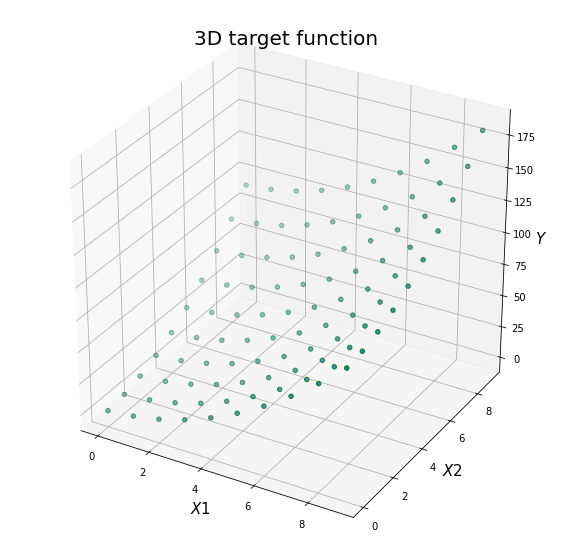

In [12]:
def target_func_2(x1, x2, alpha=1, beta=1):
    return alpha * x1 ** 2 + x1 + beta * x2 ** 2 + x2 + 1


def get_obs_y_2(obs_x1, obs_x2, alpha=1, beta=1):
    np.random.seed(1234)
    return target_func_2(obs_x1, obs_x2, alpha, beta) + np.random.normal(
        0, 10, size=obs_x1.shape[0]
    )


x1 = np.outer(np.linspace(0, 9, 10), np.ones(10))
x2 = x1.copy().T

y = target_func_2(x1, x2)
y_obs = get_obs_y_2(x1, x2)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter(x1, x2, y, cmap="viridis", edgecolor="green")
ax.set_title("3D target function", fontsize=20)
ax.set_xlabel("$X1$", fontsize=15)
ax.set_ylabel("$X2$", fontsize=15)
ax.set_zlabel("$Y$", fontsize=15)
plt.show();

### Prepare train and test data

In [13]:
max_x1 = 10
x1_range = np.array(range(max_x1))

# prepare different probability distribution for train and test data
test_weights = [(1 + i) / ((max_x1 + 1) * max_x1 / 2) for i in x1_range]
train_weights = test_weights[::-1]

x1_train_list = np.random.choice(x1_range, p=train_weights, size=sample_size)
x1_test_list = np.random.choice(x1_range, p=test_weights, size=sample_size)

max_x2 = 10
x2_range = np.array(range(max_x2))

test_weights = [(1 + i) / ((max_x2 + 1) * max_x2 / 2) for i in x2_range]
train_weights = test_weights[::-1]

x2_train_list = np.random.choice(x2_range, p=train_weights, size=sample_size)
x2_test_list = np.random.choice(x2_range, p=test_weights, size=sample_size)

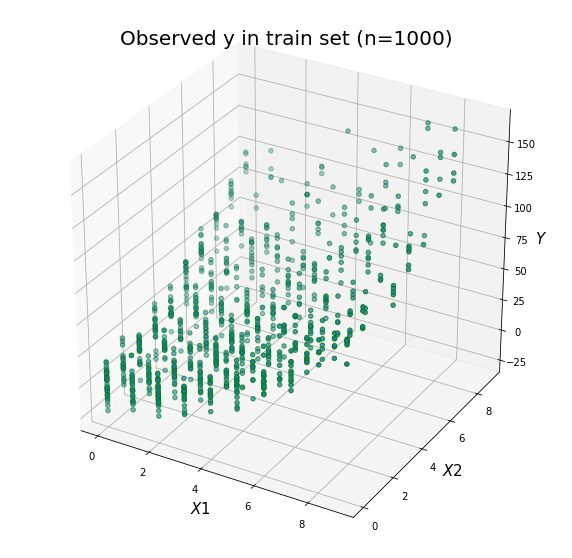

In [14]:
df_train = pd.DataFrame()
df_train["x1"] = x1_train_list
df_train["x2"] = x2_train_list
df_train["y"] = get_obs_y_2(df_train["x1"], df_train["x2"])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter(
    df_train["x1"], df_train["x2"], df_train["y"], cmap="viridis", edgecolor="green"
)
ax.set_title(f"Observed y in train set (n={sample_size})", fontsize=20)
ax.set_xlabel("$X1$", fontsize=15)
ax.set_ylabel("$X2$", fontsize=15)
ax.set_zlabel("$Y$", fontsize=15)
plt.show();

In [15]:
df_train

,x1,x2,y
0,4,6,67.714352
1,4,3,21.090243
2,2,6,63.327070
3,3,2,15.873481
4,3,4,25.794113
...,...,...,...
995,0,1,5.721640
996,2,0,16.315458
997,1,5,36.275323
998,1,4,30.408138


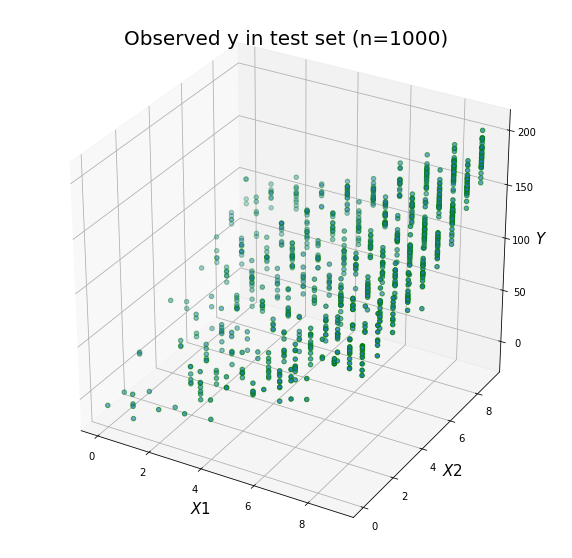

In [16]:
df_test = pd.DataFrame()
df_test["x1"] = x1_test_list
df_test["x2"] = x2_test_list
df_test["y"] = get_obs_y_2(df_test["x1"], df_test["x2"])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter(
    df_test["x1"], df_test["x2"], df_test["y"], cmap="viridis", edgecolor="green"
)
ax.set_title(f"Observed y in test set (n={sample_size})", fontsize=20)
ax.set_xlabel("$X1$", fontsize=15)
ax.set_ylabel("$X2$", fontsize=15)
ax.set_zlabel("$Y$", fontsize=15)
plt.show();

In [17]:
df_test

,x1,x2,y
0,5,9,125.714352
1,9,9,169.090243
2,6,7,113.327070
3,3,5,39.873481
4,8,8,137.794113
...,...,...,...
995,3,5,45.721640
996,0,9,100.315458
997,7,5,90.275323
998,8,1,82.408138


## Covariate shift correction in four steps

Step 1: concatenate train (label 0) and test data (label 1)

Step 2: train a classifier between train and test (could be logistic regression or multilayer perceptron classifier)

Step 3: calculate the density ratio (p1/p0) for the train set

Step 4: train the model with the weighted sample (using density ratio as the weight) 

Finally, as a validation, we will compare the RMSE of train and test data using different model results to see the effect of the correction.

### Step 1: concatenate train (label 0) and test data (label 1)

In [18]:
# Step 1: assign a label of 1 to test data set, and a label of 0 to train data set
df_test["label"] = 1
df_train["label"] = 0

# Concat the two datasets into one data set
df_combined = pd.concat(
    [df_train[["x1", "x2", "label"]], df_test[["x1", "x2", "label"]]]
)

In [19]:
df_combined

,x1,x2,label
0,4,6,0
1,4,3,0
2,2,6,0
3,3,2,0
4,3,4,0
...,...,...,...
995,3,5,1
996,0,9,1
997,7,5,1
998,8,1,1


### Step 2: train a classifier between train and test

In [20]:
def check_accuracy(df, col_y_pred, col_y_true="label"):
    accuracy = accuracy_score(df[col_y_true], df[col_y_pred])
    precision = precision_score(df[col_y_true], df[col_y_pred])
    recall = recall_score(df[col_y_true], df[col_y_pred])
    print(
        f"""
    accuracy: {round(accuracy, 3)}
    precision: {round(precision, 3)}
    recall: {round(recall, 3)}
    """
    )
    return accuracy, precision, recall

In [21]:
# Step 2: train the classifier using the combined dataset
X = df_combined[["x1", "x2"]]
y = df_combined["label"]

## Train logistic regression
clf = LogisticRegression().fit(X, y)
df_combined["label_hat_lr"] = clf.predict(df_combined[["x1", "x2"]])

print("Check the accuracy of the classifier: logistic regression")
display(_=check_accuracy(df_combined, "label_hat_lr"))

Check the accuracy of the classifier: logistic regression

    accuracy: 0.794
    precision: 0.799
    recall: 0.786
    


### Step 3: calculate the density ratio (p1/p0) for the train set

In [22]:
# Step 3: get the density ratio for training set
df_train["density_ratio"] = [
    i[1] / i[0] for i in clf.predict_proba(df_train[["x1", "x2"]])
]

df_train

,x1,x2,y,label,density_ratio
0,4,6,67.714352,0,1.633294
1,4,3,21.090243,0,0.433734
2,2,6,63.327070,0,0.758671
3,3,2,15.873481,0,0.190007
4,3,4,25.794113,0,0.459901
...,...,...,...,...,...
995,0,1,5.721640,0,0.038664
996,2,0,16.315458,0,0.053502
997,1,5,36.275323,0,0.332354
998,1,4,30.408138,0,0.213626


### Step 4: Trian models using density ratio

In [23]:
def compute_rmse(df_train, df_test, weight=None):
    X = df_train[["x1", "x2"]]
    y = df_train["y"]
    if weight:
        w = df_train[weight]
        # train a weighted model
        lr = LinearRegression().fit(X, y, w)
        df_train[f"y_hat_{weight}"] = lr.predict(X)
        df_test[f"y_hat_{weight}"] = lr.predict(df_test[["x1", "x2"]])
        print("RMSE for train set:")
        print(round(rmse(df_train["y"], df_train[f"y_hat_{weight}"]), 2))
        print("")
        print("RMSE for test set:")
        print(round(rmse(df_test["y"], df_test[f"y_hat_{weight}"]), 2))

    else:
        # train simple linear regression
        lr = LinearRegression().fit(X, y)
        df_train[f"y_hat"] = lr.predict(X)
        df_test[f"y_hat"] = lr.predict(df_test[["x1", "x2"]])
        print("RMSE for train set:")
        print(round(rmse(df_train["y"], df_train["y_hat"]), 2))
        print("")
        print("RMSE for test set:")
        print(round(rmse(df_test["y"], df_test["y_hat"]), 2))
    return df_train, df_test, lr

### Validation: Compare RMSE across models

#### No correction: simple linear regression

In [24]:
df_train, df_test, lr = compute_rmse(df_train, df_test)

RMSE for train set:
167.65

RMSE for test set:
352.05


#### With correction: weighted linear regression using density ratio

In [25]:
df_train, df_test, weighted_lr = compute_rmse(df_train, df_test, "density_ratio")

RMSE for train set:
280.07

RMSE for test set:
168.52


### Adjusting the intensity of the density_ratio

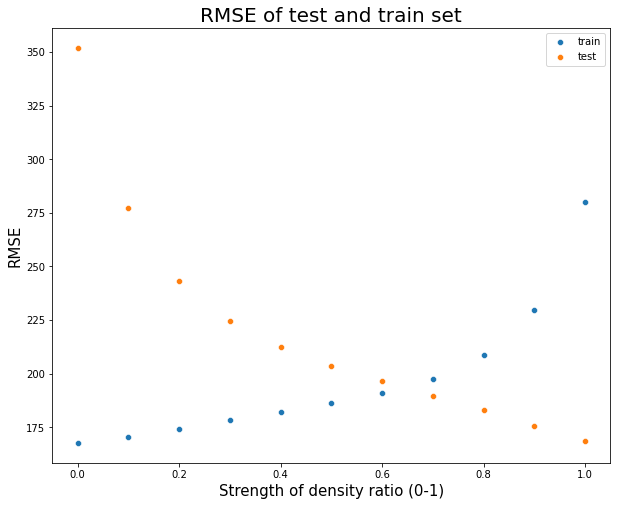

In [26]:
def compute_rmse_by_strength(df_train, df_test, weight="density_ratio", strength=None):
    X = df_train[["x1", "x2"]]
    y = df_train["y"]
    df_train["new_weight"] = (df_train[weight] - 1) * strength + 1
    lr = LinearRegression().fit(X, y, df_train["new_weight"])
    df_train["y_hat_new_weight"] = lr.predict(X)
    df_test["y_hat_new_weight"] = lr.predict(df_test[["x1", "x2"]])
    rmse_train = rmse(df_train["y"], df_train["y_hat_new_weight"])
    rmse_test = rmse(df_test["y"], df_test["y_hat_new_weight"])
    return i, rmse_train, rmse_test


df_results = pd.DataFrame(
    index=np.linspace(0, 1, 11),
    columns=["strength", "rmse_train", "rmse_test"],
    dtype=float,
)

for i in np.linspace(0, 1, 11):
    (
        df_results.loc[i, "strength"],
        df_results.loc[i, "rmse_train"],
        df_results.loc[i, "rmse_test"],
    ) = compute_rmse_by_strength(df_train, df_test, strength=i)

plt.figure(figsize=(10, 8))
_ = sns.scatterplot(data=df_results, x="strength", y="rmse_train", label="train")
_ = sns.scatterplot(data=df_results, x="strength", y="rmse_test", label="test")
_.set_ylabel("RMSE", fontsize=15)
_.set_xlabel("Strength of density ratio (0-1)", fontsize=15)
_.set_title("RMSE of test and train set", fontsize=20);

-----
# Summary

## Covariate shift

Covariate shift refers to the changes in the **distribution of features in the training and test** dataset.


## Covariate shift correction: importance weight using density ratio

The key idea behind the general approach of covariate shift correction is to **train a classifier** between the training and test set. 

Then we can get the **density ratio** of p_test(x)/p_train(x) and use it to **reweight** the training set for training the final model.


Notes: 

- p_train(x): the probability of a sample comes from the training dataset given a set of features 

- p_test(x): the probability of a sample comes from the test dataset given a set of features

- density ratio: p_test(x)/p_train(x)

## Challenges?
Although the demos in this notebook seem promising and easy to implement, the application of covariate shift correction in the real world is still questionable:
- Need to have knowledge of the test data
- Need to have some knowledge of the target function
- Need to identify if there is a covariate shift or not
- Training the classifier is very time consuming for high-dimension dataset
- Uncertain results: It is possible that using a model that corrects for covariate shift may produce worse results than using a standard model without the correction.

------
# Advanced topics

## More background knowledge:

**Types of dataset shift:**

- **covariate shift**: the shift of the feature(s) distribution
- **prior probability shift**: the shift of the target distribution
- **concept shift**:  the shift of the relationship between the target and the feature(s)
- **domain shift**: involves changes in measurement


**How to identify covariate shift?**
- visualize feature distribution 
- train a classifier for the combined data method (check for each feature) 
    - if AUC-ROC is larger than 0.8 --> drifting feature (see "Steps to identify drift" section in the first reference [link](https://www.analyticsvidhya.com/blog/2017/07/covariate-shift-the-hidden-problem-of-real-world-data-science/))


**Two methods of dealing with covariate shift:** 
- dropping of drifting features
- importance weight using density ratio estimation
    - train a classifier yourself
    - use a package like [densratio](https://github.com/hoxo-m/densratio_py) to get density ratio

## Frequently asked questions:

### Q1: What if the classifier model is not accurate enough?

**Answer:**
- Situation 1: not too much signal in distinguishing train and test set  --> no need to do covariate shift correction
- Situation 2: the classifier is not good enough to describe the feature difference between test and train set  --> improve the classifier (logistic regression -> MLP)

**Simulation**: 

Train a less accurate classifier by reducing the number of features

In [27]:
# Bonus test: train a "poor" classifier using less features
X1 = df_combined[["x1"]]
y = df_combined["label"]

## Train logistic regression
clf1 = LogisticRegression().fit(X1, y)
df_combined["label_hat_lr_1"] = clf1.predict(df_combined[["x1"]])

print("Check the accuracy of the classifier: logistic regression with only 1 feature")
display(_=check_accuracy(df_combined, "label_hat_lr_1"))

# add the density ratio using the logistic regression model
df_train["density_ratio_1"] = [
    i[1] / i[0] for i in clf1.predict_proba(df_train[["x1"]])
]

df_train, df_test, weighted_lr_1 = compute_rmse(df_train, df_test, "density_ratio_1")

Check the accuracy of the classifier: logistic regression with only 1 feature

    accuracy: 0.706
    precision: 0.709
    recall: 0.696
    
RMSE for train set:
219.39

RMSE for test set:
240.58


We can compare the results of a poor classifier (above: with 1 feature) with the results of a good classifier (below: with 2 features):

In [28]:
df_results.round(2)

,strength,rmse_train,rmse_test
0.0,0.0,167.65,352.05
0.1,0.1,170.26,277.23
0.2,0.2,174.39,243.16
0.3,0.3,178.42,224.36
0.4,0.4,182.28,212.35
0.5,0.5,186.30,203.62
0.6,0.6,191.08,196.44
0.7,0.7,197.74,189.80
0.8,0.8,208.69,183.05
0.9,0.9,229.90,175.76


### Q2: What if the sample size in the train set does not equal to the sample size in the test set?

**Answer:**

It is no problem when using the approach in the first demo (see simulation below).

However, when training the classifier as in the second approach, it is not recommended to use p_test(x)/p_train(x) directly, as it will result in a list of density ratios that are not centered at the value of 1.

Two solutions:
- resample the training or test set to make the sample sizes equal
- after getting the density ratio, adjust it based on the sample size ratio (n_test/n_train)

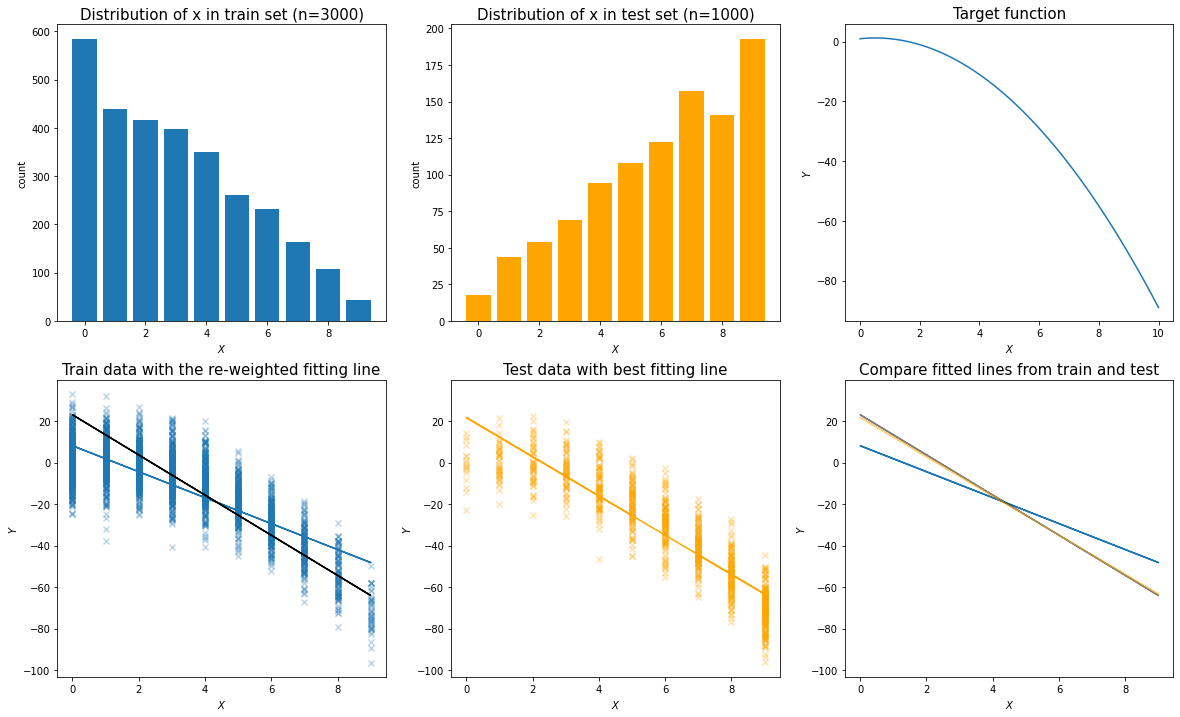

In [29]:
# No difference if we use the approach in demo 1
# customize sample size
train_sample_size = 3000
test_sample_size = 1000

# set other parameters
sample_size = 1000
max_x = 10
x_range = np.array(range(max_x))

# define functions
def target_func(x, eps=-1):
    return eps * x ** 2 + x + 1

def get_obs_y(obs_x, eps=-1):
    np.random.seed(1234)
    return target_func(obs_x, eps) + np.random.normal(0, 10, size=obs_x.shape[0])

# prepare different probability distribution for train and test data
test_weights = [(1 + i) / ((max_x + 1) * max_x / 2) for i in x_range]
train_weights = test_weights[::-1]

# generate x, y, and best fitting line for train data
x_train_list = np.random.choice(x_range, p=train_weights, size=train_sample_size)
y_train_list = get_obs_y(x_train_list)
linreg_train = sm.OLS(y_train_list, sm.add_constant(x_train_list)).fit()

# generate x, y, and best fitting line for test data
x_test_list = np.random.choice(x_range, p=test_weights, size=test_sample_size)
y_test_list = get_obs_y(x_test_list)
linreg_test = sm.OLS(y_test_list, sm.add_constant(x_test_list)).fit()

# prepare distribution plot for train and test set
def prepare_distribution(x_list):
    df = pd.DataFrame(x_list)
    df.columns = ["x"]
    df = df.groupby("x").agg({"x": "count"})
    df.columns = ["frequency"]
    df = df.reset_index()
    return df

dist_test = prepare_distribution(x_test_list)
dist_train = prepare_distribution(x_train_list)

# prepare density ratio
dist_train["p"] = dist_train["frequency"] / (dist_train["frequency"].sum())
dist_test["p"] = dist_test["frequency"] / (dist_test["frequency"].sum())
weight = dist_test["p"] / dist_train["p"]
weight_dict = weight.to_dict()
weight_list = [weight_dict[x] for x in x_train_list]

# retrain the model using re-weighted sample
weighted_linreg_train = sm.WLS(
    y_train_list, sm.add_constant(x_train_list), weight_list
).fit()

# visualize data
fig, axes = plt.subplots(figsize=(20, 12), ncols=3, nrows=2)
axes = axes.flatten()

axes[0].set_title(
    f"Distribution of x in train set (n={train_sample_size})", fontsize=15
)
axes[0].bar(dist_train["x"], dist_train["frequency"])
axes[0].set_xlabel("$X$")
axes[0].set_ylabel("count")

axes[1].set_title(f"Distribution of x in test set (n={test_sample_size})", fontsize=15)
axes[1].bar(dist_test["x"], dist_test["frequency"], color="orange")
axes[1].set_xlabel("$X$")
axes[1].set_ylabel("count")

axes[2].set_title("Target function", fontsize=15)
x = np.linspace(0, 10, 100)
axes[2].plot(x, target_func(x))
axes[2].set_xlabel("$X$")
axes[2].set_ylabel("$Y$")

axes[3].set_title("Train data with the re-weighted fitting line", fontsize=15)
axes[3].scatter(x_train_list, y_train_list, alpha=0.3, marker="x")
axes[3].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[3].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
)
axes[3].set_xlabel("$X$")
axes[3].set_ylabel("$Y$")

axes[4].set_title("Test data with best fitting line", fontsize=15)
axes[4].scatter(x_test_list, y_test_list, color="orange", alpha=0.3, marker="x")
axes[4].plot(
    x_test_list, linreg_test.predict(sm.add_constant(x_test_list)), color="orange"
)
axes[4].set_xlabel("$X$")
axes[4].set_ylabel("$Y$")
axes[4].set_ylim(axes[3].get_ylim())

axes[5].set_title("Compare fitted lines from train and test", fontsize=15)
axes[5].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[5].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
    alpha=0.5,
)
axes[5].plot(
    x_test_list,
    linreg_test.predict(sm.add_constant(x_test_list)),
    color="orange",
    alpha=0.5,
)
axes[5].set_xlabel("$X$")
axes[5].set_ylabel("$Y$")
axes[5].set_ylim(axes[3].get_ylim())

plt.show()

### What if the target function is perfectly linear?

**Answer:**

There is no need to do covariate shift correction if the target function is perfectly linear and the main model is also linear.

- Situation 1: When the error term in the observed data is relatively small, there should be no impact. 
- Situation 2: When the error term in the observation data is large, then the prediction bias is mainly from the error term in the train and test data. The covariate shift correction will not work as well.

**Simulation for Situation 1**: relative small error term when generating the simulation data

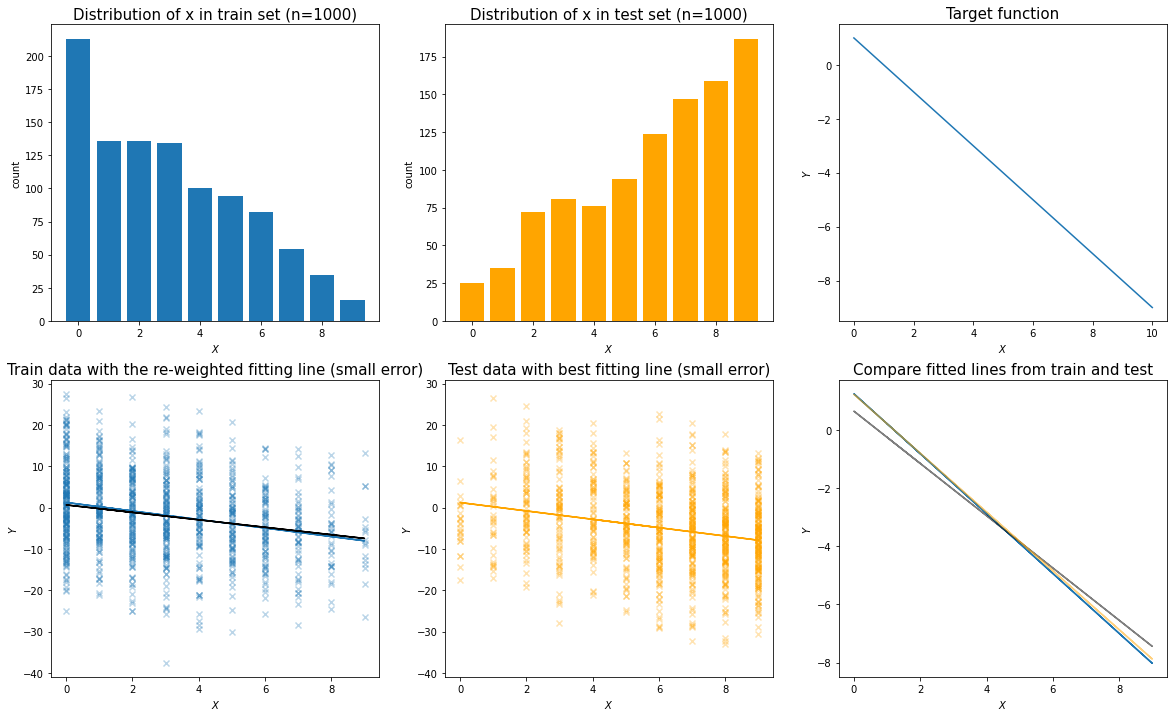

In [30]:
# Prepare data: small error
error = 10

# set other parameters
sample_size = 1000
max_x = 10
x_range = np.array(range(max_x))

# define functions
def target_func(x, eps=-1):
    return eps * x + 1

def get_obs_y(obs_x, eps=-1, error=error):
    np.random.seed(1234)
    return target_func(obs_x, eps) + np.random.normal(0, error, size=obs_x.shape[0])

# prepare different probability distribution for train and test data
test_weights = [(1 + i) / ((max_x + 1) * max_x / 2) for i in x_range]
train_weights = test_weights[::-1]

# generate x, y, and best fitting line for train data
x_train_list = np.random.choice(x_range, p=train_weights, size=sample_size)
y_train_list = get_obs_y(x_train_list)
linreg_train = sm.OLS(y_train_list, sm.add_constant(x_train_list)).fit()

# generate x, y, and best fitting line for test data
x_test_list = np.random.choice(x_range, p=test_weights, size=sample_size)
y_test_list = get_obs_y(x_test_list)
linreg_test = sm.OLS(y_test_list, sm.add_constant(x_test_list)).fit()

# prepare distribution plot for train and test set
def prepare_distribution(x_list):
    df = pd.DataFrame(x_list)
    df.columns = ["x"]
    df = df.groupby("x").agg({"x": "count"})
    df.columns = ["frequency"]
    df = df.reset_index()
    return df

dist_test = prepare_distribution(x_test_list)
dist_train = prepare_distribution(x_train_list)

# prepare density ratio
dist_train["p"] = dist_train["frequency"] / (dist_train["frequency"].sum())
dist_test["p"] = dist_test["frequency"] / (dist_test["frequency"].sum())
weight = dist_test["p"] / dist_train["p"]
weight_dict = weight.to_dict()
weight_list = [weight_dict[x] for x in x_train_list]

# retrain the model using re-weighted sample
weighted_linreg_train = sm.WLS(
    y_train_list, sm.add_constant(x_train_list), weight_list
).fit()

# visualize data
fig, axes = plt.subplots(figsize=(20, 12), ncols=3, nrows=2)
axes = axes.flatten()

axes[0].set_title(f"Distribution of x in train set (n={sample_size})", fontsize=15)
axes[0].bar(dist_train["x"], dist_train["frequency"])
axes[0].set_xlabel("$X$")
axes[0].set_ylabel("count")

axes[1].set_title(f"Distribution of x in test set (n={sample_size})", fontsize=15)
axes[1].bar(dist_test["x"], dist_test["frequency"], color="orange")
axes[1].set_xlabel("$X$")
axes[1].set_ylabel("count")

axes[2].set_title("Target function", fontsize=15)
x = np.linspace(0, 10, 100)
axes[2].plot(x, target_func(x))
axes[2].set_xlabel("$X$")
axes[2].set_ylabel("$Y$")

axes[3].set_title(
    "Train data with the re-weighted fitting line (small error)", fontsize=15
)
axes[3].scatter(x_train_list, y_train_list, alpha=0.3, marker="x")
axes[3].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[3].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
)
axes[3].set_xlabel("$X$")
axes[3].set_ylabel("$Y$")

axes[4].set_title("Test data with best fitting line (small error)", fontsize=15)
axes[4].scatter(x_test_list, y_test_list, color="orange", alpha=0.3, marker="x")
axes[4].plot(
    x_test_list, linreg_test.predict(sm.add_constant(x_test_list)), color="orange"
)
axes[4].set_xlabel("$X$")
axes[4].set_ylabel("$Y$")
axes[4].set_ylim(axes[3].get_ylim())

axes[5].set_title("Compare fitted lines from train and test", fontsize=15)
axes[5].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[5].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
    alpha=0.5,
)
axes[5].plot(
    x_test_list,
    linreg_test.predict(sm.add_constant(x_test_list)),
    color="orange",
    alpha=0.5,
)
axes[5].set_xlabel("$X$")
axes[5].set_ylabel("$Y$")

plt.show()

**Simulation for Situation 2**: relative large error term when generating the simulation data

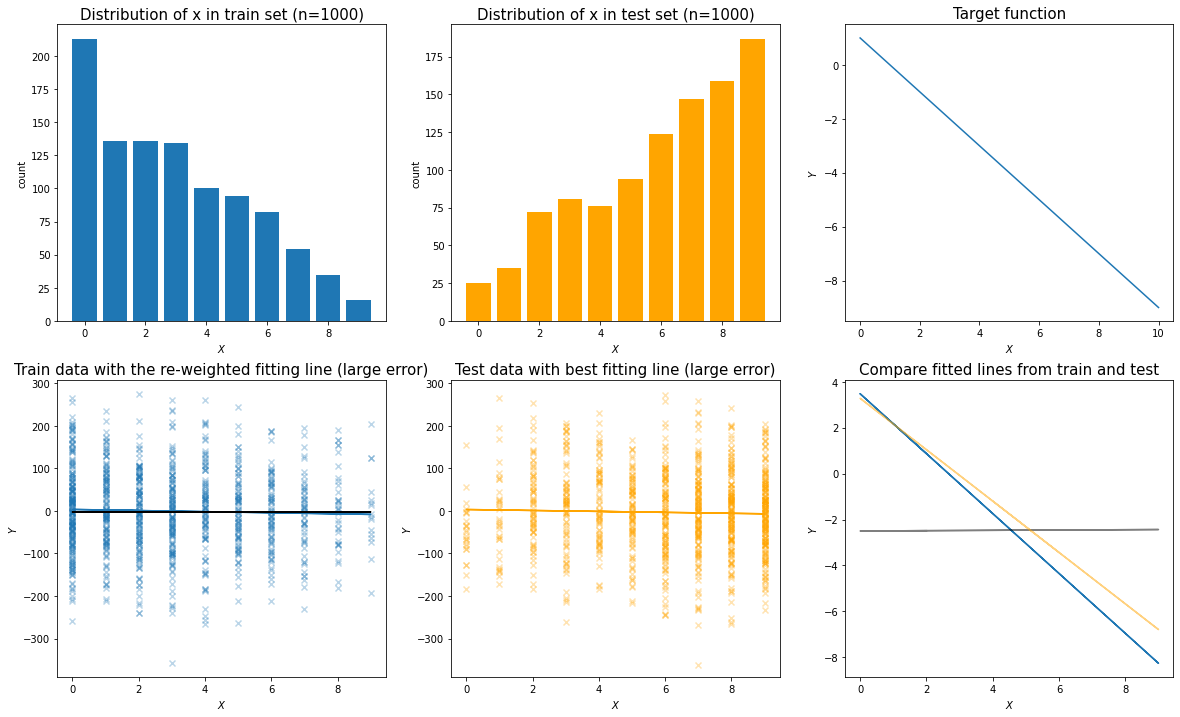

In [31]:
# Prepare data: large error
error = 100

# set other parameters
sample_size = 1000
max_x = 10
x_range = np.array(range(max_x))

# define functions
def target_func(x, eps=-1):
    return eps * x + 1

def get_obs_y(obs_x, eps=-1, error=error):
    np.random.seed(1234)
    return target_func(obs_x, eps) + np.random.normal(0, error, size=obs_x.shape[0])

# prepare different probability distribution for train and test data
test_weights = [(1 + i) / ((max_x + 1) * max_x / 2) for i in x_range]
train_weights = test_weights[::-1]

# generate x, y, and best fitting line for train data
x_train_list = np.random.choice(x_range, p=train_weights, size=sample_size)
y_train_list = get_obs_y(x_train_list)
linreg_train = sm.OLS(y_train_list, sm.add_constant(x_train_list)).fit()

# generate x, y, and best fitting line for test data
x_test_list = np.random.choice(x_range, p=test_weights, size=sample_size)
y_test_list = get_obs_y(x_test_list)
linreg_test = sm.OLS(y_test_list, sm.add_constant(x_test_list)).fit()

# prepare distribution plot for train and test set
def prepare_distribution(x_list):
    df = pd.DataFrame(x_list)
    df.columns = ["x"]
    df = df.groupby("x").agg({"x": "count"})
    df.columns = ["frequency"]
    df = df.reset_index()
    return df

dist_test = prepare_distribution(x_test_list)
dist_train = prepare_distribution(x_train_list)

# prepare density ratio

dist_train["p"] = dist_train["frequency"] / (dist_train["frequency"].sum())
dist_test["p"] = dist_test["frequency"] / (dist_test["frequency"].sum())
weight = dist_test["p"] / dist_train["p"]
weight_dict = weight.to_dict()
weight_list = [weight_dict[x] for x in x_train_list]

# retrain the model using re-weighted sample
weighted_linreg_train = sm.WLS(
    y_train_list, sm.add_constant(x_train_list), weight_list
).fit()

# visualize data
fig, axes = plt.subplots(figsize=(20, 12), ncols=3, nrows=2)
axes = axes.flatten()

axes[0].set_title(f"Distribution of x in train set (n={sample_size})", fontsize=15)
axes[0].bar(dist_train["x"], dist_train["frequency"])
axes[0].set_xlabel("$X$")
axes[0].set_ylabel("count")

axes[1].set_title(f"Distribution of x in test set (n={sample_size})", fontsize=15)
axes[1].bar(dist_test["x"], dist_test["frequency"], color="orange")
axes[1].set_xlabel("$X$")
axes[1].set_ylabel("count")

axes[2].set_title("Target function", fontsize=15)
x = np.linspace(0, 10, 100)
axes[2].plot(x, target_func(x))
axes[2].set_xlabel("$X$")
axes[2].set_ylabel("$Y$")

axes[3].set_title(
    "Train data with the re-weighted fitting line (large error)", fontsize=15
)
axes[3].scatter(x_train_list, y_train_list, alpha=0.3, marker="x")
axes[3].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[3].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
)
axes[3].set_xlabel("$X$")
axes[3].set_ylabel("$Y$")

axes[4].set_title("Test data with best fitting line (large error)", fontsize=15)
axes[4].scatter(x_test_list, y_test_list, color="orange", alpha=0.3, marker="x")
axes[4].plot(
    x_test_list, linreg_test.predict(sm.add_constant(x_test_list)), color="orange"
)
axes[4].set_xlabel("$X$")
axes[4].set_ylabel("$Y$")
axes[4].set_ylim(axes[3].get_ylim())

axes[5].set_title("Compare fitted lines from train and test", fontsize=15)
axes[5].plot(x_train_list, linreg_train.predict(sm.add_constant(x_train_list)))
axes[5].plot(
    x_train_list,
    weighted_linreg_train.predict(sm.add_constant(x_train_list)),
    color="black",
    alpha=0.5,
)
axes[5].plot(
    x_test_list,
    linreg_test.predict(sm.add_constant(x_test_list)),
    color="orange",
    alpha=0.5,
)
axes[5].set_xlabel("$X$")
axes[5].set_ylabel("$Y$")

plt.show()

# Quiz answers

Answer to Quiz 1: Left

Answer to Quiz 2: Option B

# References

https://www.analyticsvidhya.com/blog/2017/07/covariate-shift-the-hidden-problem-of-real-world-data-science/

http://iwann.ugr.es/2011/pdf/InvitedTalk-FHerrera-IWANN11.pdf

https://paper.dropbox.com/doc/Brainstorm-live-c2b-re-weighting-implementation--BOKQVNRcqH6Nfyzem1as1eX9Ag-lT8BRRPma9YZOfwNG2xHI

https://www.youtube.com/watch?v=24YZ_62Jn-o&ab_channel=AlexSmola​